In [2]:
%config InlineBackend.figure_format = 'retina'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from fintools import calculate_return

In [14]:
file_path = "data_files/financial_basis/all_stocks_5yr.csv"
df = pd.read_csv(file_path, parse_dates = ['date'])

def select_stock(stock:str):
    return df[df['Name'] == stock].copy().pipe(calculate_return)

sbux = select_stock("SBUX")

In [23]:
with pm.Model() as model:
    nu = pm.Exponential('nu', 1/10)
    sigma = pm.Exponential('sigma', 1/10)
    mu = pm.Normal("mu",mu = 0, sigma = 1)
    y = pm.StudentT("y",nu = nu, mu = mu, sigma = sigma, observed = sbux['net_return'].dropna())
    trace = pm.sample(1000, tune = 1000, chains = 2,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8790652085309544, but should be close to 0.8. Try to increase the number of tuning steps.


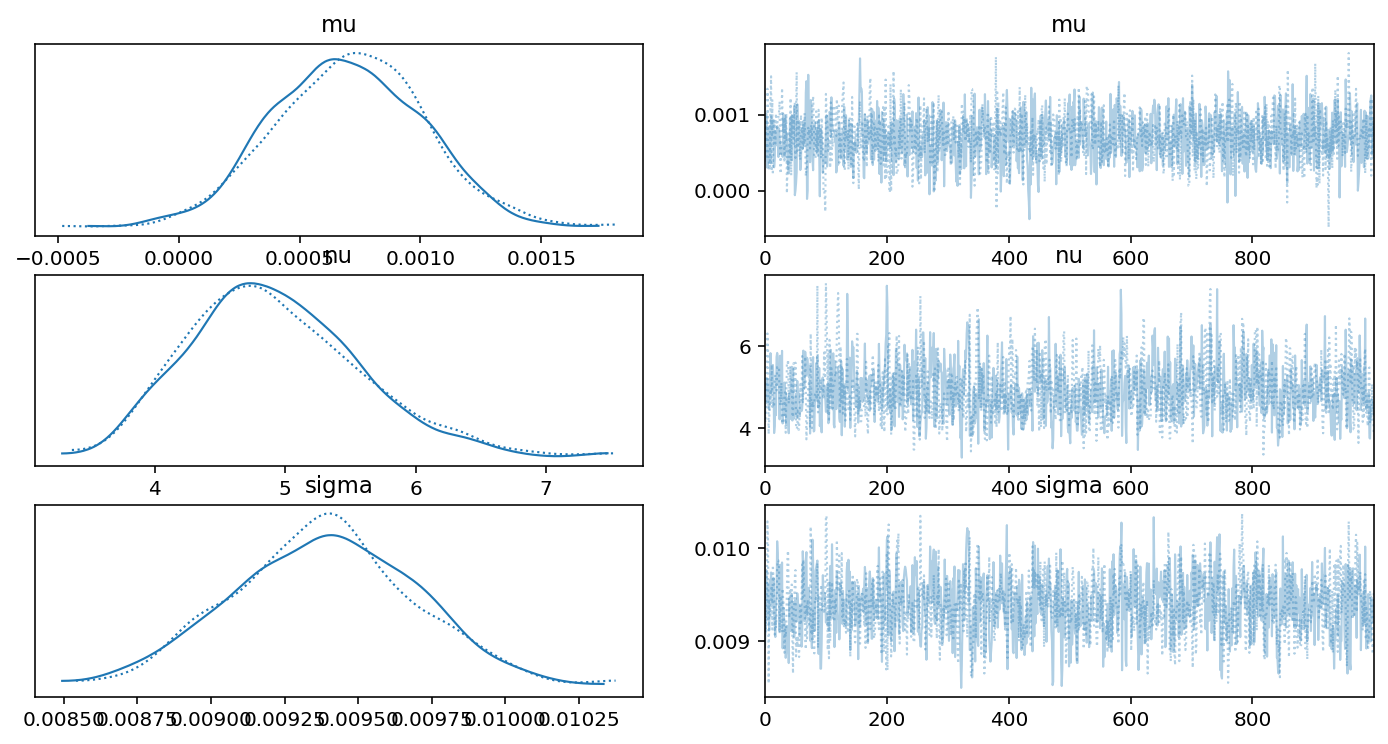

In [27]:
az.plot_trace(trace)
plt.show()

In [28]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.000,0.000,0.001,0.000,0.000,1621.0,1292.0,1.0
nu,4.927,0.664,3.718,6.133,0.022,0.015,958.0,1144.0,1.0
sigma,0.009,0.000,0.009,0.010,0.000,0.000,981.0,1182.0,1.0


In [29]:
with model:
    pp = pm.sample_posterior_predictive(trace, samples = 1000)

/opt/anaconda3/envs/mcmc/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Posterior Predictive Check

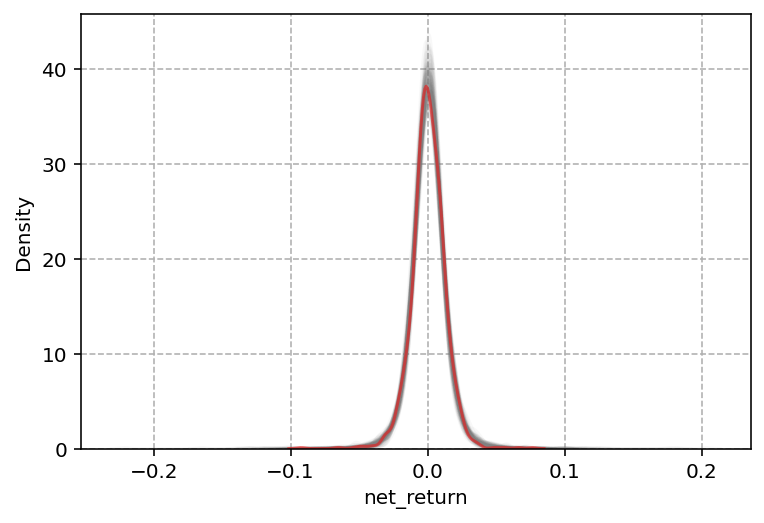

In [62]:
import seaborn as sns
for pp_sample in pp['y'][-100:]:
    sns.kdeplot(pp_sample, color = 'gray', alpha = 0.05)
sns.kdeplot(sbux['net_return'].dropna(), color = 'red', alpha = 0.5)
plt.grid(linestyle = '--')
plt.show()